# Математические инструменты

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

### Проверка отрисовки графика

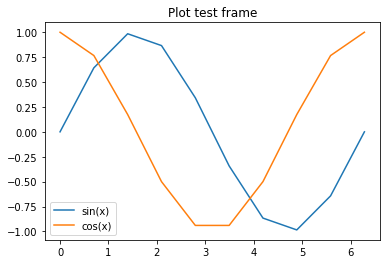

In [34]:
plt.title("Plot test frame")
x = np.linspace(0, 2*math.pi, 10)
plt.plot(x, np.sin(x), label="sin(x)")
plt.plot(x, np.cos(x), label="cos(x)")
plt.legend();

In [35]:
x = np.linspace(0, 2*math.pi)

sin_trace = go.Scatter(x = x, y = np.sin(x), name= "sin")
cos_trace = go.Scatter(x = x, y = np.cos(x), name= "cos")

iplot([sin_trace, cos_trace], filename='basic-line')

## Численное интегрирование

### Вариант 1: простой интеграл Римана
Фиксированное количество точек. Интеграл всегда сходится, но точность результата зависит от функции.

In [4]:
def integrateR(func, a, b, numPoints = 100):
    points, step = np.linspace(a, b, numPoints, endpoint=True, retstep=True)
    return np.sum(func(points))*step

### Вариант 2: итеративный интеграл Симпсона 
[Квадратичная формула Симпсона](http://mathworld.wolfram.com/SimpsonsRule.html). Первый аргумент - сама функция, второй и третий - границы интегрирования. 

In [5]:
from scipy.integrate import simps
def integrateS(func, a, b, numPoints = 100):
    x = np.linspace(a,b, numPoints, endpoint=True)
    return simps(x = x, y = func(x))

## Вариант 3: "Умное" итеративное интегрирование
Используется [итеративный численный интегратор из библиотеки SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html).
Итеративная формула гарантирует точность интегрирования, но не гарантирует сходимости.

In [6]:
from scipy.integrate import quad
def integrateQ(func, a, b):
    res = quad(func, a,b)
    return res[0]

### Интегратор по умолчанию
В качестве интегратора по умолчанию выбираем интегратор Римана. Если захотим использовать другой, надо переопределить переменную `integrate,` например вот так:

`integrate = integrateS`

In [36]:
integrate = integrateS

### Проверяем, что интегратор работает

Интеграл Римана 10 точек:

In [37]:
integrate(np.sin,0,math.pi,10)

1.9995487365804032

Интеграл Римана 100 точек:

In [39]:
integrateR(np.sin,0,math.pi,100)

1.9998321638939927

Интеграл Римана 200 точек:

In [40]:
integrateR(np.sin,0,math.pi,200)

1.9999584621373308

Интеграл Симпсона 10 точек

In [41]:
integrateS(np.sin,0,math.pi,10)

1.9995487365804032

Итеративный интеграл:

In [42]:
integrateQ(np.sin,0, math.pi)

2.0

## Свертка

[Сверткой](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BA%D0%B0_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7)) 
двух функций называется следующее интегральное преобразование:
$$
  h(x) = f(x) \otimes g(x) = \int {f(x-y) g(y) dy }
$$
Интегрирование ведется по всей области определения функций. Очевидно, что переменные под интегрированием можно менять местами.

In [43]:
convolute = lambda f, g, a, b: np.vectorize(
    lambda x: integrate(lambda y: f(x-y)*g(y), a, b)
)

# def convolute(f,g,a,b):
#     def res (x):
#         return integrate(lambda y: f(x-y)*g(y), a, b)
#     return res

### Проверяем работу свертки

Проверяем работу свертки, взяв в качестве одной функции ступеньку, а в качестве другой Гауссиану. Параметры `wStep` и `sigma` можно менять по своему усмотрению для получения различного результата.

In [45]:
wStep = 4; # Ширина ступеньки
sigma = 0.8;# Стандартное отклонение Гауссианы

# ступенька
f = lambda x: 1/wStep if (x >= -wStep/2 and x<= wStep/2) else 0.0 # нормировка на единицу
f = np.vectorize(f)

# Функция Гаусса
g = lambda x : 1/np.sqrt(2*math.pi)/sigma*np.exp(-x*x/2/sigma/sigma)

# Plot plot = new Plot(title: "Convolution test plot", showLegend: true)


# автоматическое определение окна интегрирования и отрисовки
wind = max(2*wStep, 4*sigma)
x = np.linspace(-wind, wind, 200)

traces = [
    go.Scatter(x = x, y = f(x), name = "f(x)"),
    go.Scatter(x = x, y = g(x), name = "g(x)"),
    go.Scatter(x = x, y = convolute(f,g, -wind, wind)(x), name = "convolution")
]

iplot(traces)

## Интерполяция

При использовании численных методов часто нужно уметь не только вычислить функцию, но и сохранить ее значения в виде таблицы для дальнейших вычислений.
В данном случае используется кубический сплайн-интерполятор из библиотеки commons-math. Сплайн-интерполяторы характерны тем, что выдают гладкую функцию, проходящую через все заданные точки. 
Легко видно, что для функций с большой степенью гладкости такой интерполятор будет выдавать хорошее приближение даже при сравнительно маленьком количестве узлов.

In [46]:
from scipy.interpolate import CubicSpline

def interpolate(func, a, b, numPoints=300):
    xs = np.linspace(a,b, numPoints, endpoint=True)
    spline = CubicSpline(xs, func(xs), extrapolate=False)
    
    def my_spline(x):
        if x<a:
            return spline(a)
        elif x>b:
            return spline(b)
        else:
            return spline(x)
        
    return np.vectorize(my_spline)

### Проверка работы интерполятора

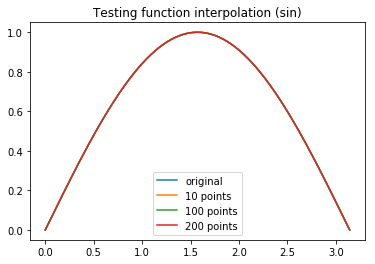

In [47]:
plt.title("Testing function interpolation (sin)")
x = np.linspace(0, math.pi, 300, endpoint=True)
plt.plot(x, np.sin(x), label="original")
plt.plot(x, interpolate(np.sin, 0, math.pi, 10)(x), label="10 points")
plt.plot(x, interpolate(np.sin, 0, math.pi, 100)(x), label="100 points")
plt.plot(x, interpolate(np.sin, 0, math.pi, 200)(x), label="200 points")
plt.legend();

In [48]:
x = np.linspace(-1, 1, 300, endpoint=True)
# ступенька
f = lambda x: 1 if (x >= -0.5 and x<= 0.5) else 0.0 # нормировка на единицу
f = np.vectorize(f)

traces = [
    go.Scatter(x = x, y = f(x), name = "original"),
    go.Scatter(x = x, y = interpolate(f, -1, 1, 10)(x), name="10 points"),
    go.Scatter(x = x, y = interpolate(f, -1, 1, 100)(x), name="100 points"),
    go.Scatter(x = x, y = interpolate(f, -1, 1, 200)(x), name="200 points"),
    go.Scatter(x = x, y = interpolate(f, -1, 1, 300)(x), name="300 points"),
]

iplot(traces)

# Распределения

## Равномерное распределение

Равномерное распределение говорит о том, что величина может принимать любое значение в заданном интервале $(a,b)$ с равной вероятностью.

*Распределение:* 
$$
  f(x) = 1/(b-a),  a < x < b
$$

Равномерное распределение с конечными пределами указывает на то, что величина лежит строго в заданном интервале, но ее точное значение в этом интервале неизвестно.
В случае бесконечных пределов нормировка равномерного распределения расходится, но его все равно можно использовать.

*Среднее значение:* 
$
  \mu = (b-a)/2
$

*Дисперсия:* 
$
  D = (b-a)^2/12
$

In [49]:
uniform = lambda a,b: np.vectorize(lambda x: 1/(b-a) if (x>=a and x<=b) else 0.0)

### Демонстрация равномерного распределения

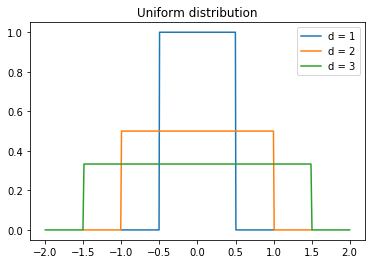

In [50]:
plt.title("Uniform distribution")
x = np.linspace(-1,1,300, endpoint=True)
plt.plot(x, uniform(-0.5, 0.5)(x), label="d = 1")
x = np.linspace(-1.5,1.5,300, endpoint=True)
plt.plot(x, uniform(-1, 1)(x), label="d = 2")
x = np.linspace(-2,2,300, endpoint=True)
plt.plot(x, uniform(-1.5, 1.5)(x), label="d = 3");
plt.legend();

## Биномиальное распределение

Биномиальное распределение описывает вероятность получить число "успехов" $k$ при проведении $n$ экспериментов при условии, что вероятность успеха в одном эксперименте равна $p$.

*Распределение:* 
$$
   p(k) = \frac{n!}{k! (n-k!)} p^k (1-p)^{n-k}
$$

*Среднее значение:* 
$
  \mu  = np
$

*Дисперсия:* 
$
  D = np(1-p)
$

Для вычислений используется [библиотечная функция](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom.html)

In [20]:
from scipy.stats import binom

### Демонстрация биномиального распределения

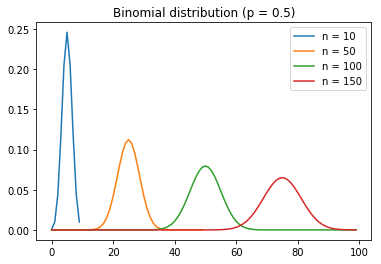

In [51]:
plt.title("Binomial distribution (p = 0.5)")
p =0.5
x = range(0,10)
plt.plot(x, binom.pmf(x,10,p), label="n = 10")
x = range(0,50)
plt.plot(x, binom.pmf(x,50,p), label="n = 50")
x = range(0,100)
plt.plot(x, binom.pmf(x,100,p), label="n = 100");
x = range(0,100)
plt.plot(x, binom.pmf(x,150,p), label="n = 150");
plt.legend();

## Распределение Пуассона

Распределение Пуассона описывает вероятность насчитать количество событий $k$ при условии, что все события равновероятны, а сренее количество таких событий равно $\lambda$. 
Это распределение - одно из самых распространенных в физике, поскольку описывает отклонение от среднего в процессе достаточно произвольного вида.

*Распределение:* 
$$
   p(k) = \frac{\lambda^k}{k!} e^{-\lambda}
$$

*Среднее значение:* 
$
  \mu  = \lambda
$

*Дисперсия:* 
$
  D = \lambda
$

Для вычислений используется [библиотечная функция](http://commons.apache.org/proper/commons-math/javadocs/api-3.5/org/apache/commons/math3/distribution/PoissonDistribution.html)

In [22]:
from scipy.stats import poisson

### Демонстрация распределения Пуассона

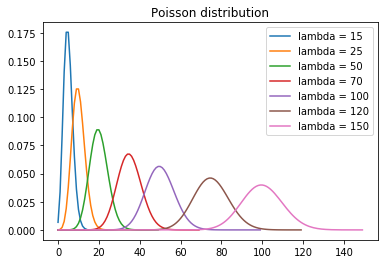

In [52]:
plt.title("Poisson distribution")
for i, mean in zip([15,25,50,70,100,120,150], [5,10,20,35,50,75,100]):
    x = range(0,i)
    plt.plot(x, poisson.pmf(x,mean), '-', label="lambda = {:d}".format(i))
plt.legend();

## Нормальное распределение

Нормальное или Гауссово распределение - наиболее часто встречается в физике (и не только). Оно является предельным случаем распределение Пуассона при больших $\lambda$, 
а также всегда всплывает при усреднеии случайных величин в силу *центральной предельной теоремы*.

*Распределение:* 
$$
   f(x, \mu, \sigma) = \frac {1}{\sqrt{2\pi} \sigma} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}
$$

*Среднее значение:* 
$
  \mu 
$

*Дисперсия:* 
$
  D = \sigma^2
$

Параметр $\sigma$ называют стандартным отклонением и именно он в большинстве случаев используется для оценки погрешности эксперимента.

In [53]:
# Функция Гаусса
gauss = lambda mu, sigma: lambda x : 1/np.sqrt(2*math.pi)/sigma*np.exp(-(x-mu)*(x-mu)/2/sigma/sigma)

### Демонстрация распределения Гаусса

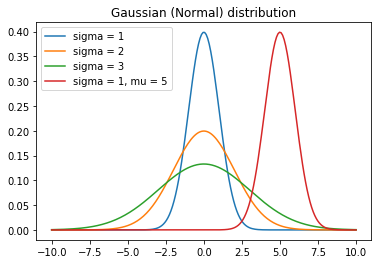

In [54]:
plt.title("Gaussian (Normal) distribution")
x = np.linspace(-10,10, 200)
plt.plot(x, gauss(0,1)(x), label="sigma = 1")
plt.plot(x, gauss(0,2)(x), label="sigma = 2")
plt.plot(x, gauss(0,3)(x), label="sigma = 3")
plt.plot(x, gauss(5,1)(x), label="sigma = 1, mu = 5")
plt.legend();

## Распределение Коши

Распределение Коши (или Лорнца или Брейта-Вигнера) описывает резонансные процессы в физике.

*Распределение:* 
$$
   f(x, \mu, \gamma) = \frac {1}{\pi} \frac{\gamma}{ (x-\mu)^2 + \gamma^2}
$$

*Среднее значение:*  не определено

*Дисперсия:*  распеделение Коши имеет бесконечную дисперсию (интеграл расходится).

In [26]:
cauchy = lambda mu,gamma : lambda x : 1/math.pi * gamma/ ((x-mu)*(x-mu)+gamma*gamma)

### Демонстрация распределения Коши

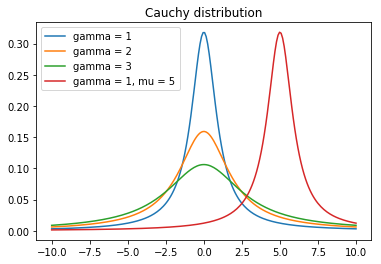

In [27]:
plt.title("Cauchy distribution")
x = np.linspace(-10,10,200)
plt.plot(x, cauchy(0,1)(x), label="gamma = 1")
plt.plot(x, cauchy(0,2)(x), label="gamma = 2")
plt.plot(x, cauchy(0,3)(x), label="gamma = 3")
plt.plot(x, cauchy(5,1)(x), label="gamma = 1, mu = 5")
plt.legend();

## Сравнение распределений

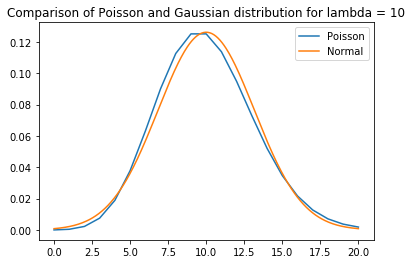

In [55]:
lambda_ = 10

plt.title("Comparison of Poisson and Gaussian distribution for lambda = " + str(lambda_));
xg = np.linspace(0, 2*lambda_, 300)
xp = range(2*lambda_ + 1)
plt.plot(xp, poisson.pmf(xp, lambda_), label="Poisson")
plt.plot(xg, gauss(lambda_, np.sqrt(lambda_))(xg), label="Normal")
plt.legend();

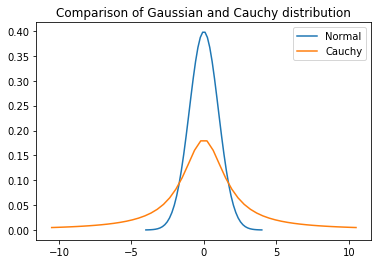

In [29]:
sigma = 1;
gamma = 1.75;
xg = np.linspace(-4*sigma, 4*sigma)
xc = np.linspace(-6*gamma, 6*gamma)
plt.title("Comparison of Gaussian and Cauchy distribution");
plt.plot(xg, gauss(0, sigma)(xg),label="Normal")
plt.plot(xc, cauchy(0, gamma)(xc),label="Cauchy" )
plt.legend();

## Центральная предельная теорема

Центральная предельная теоремма утверждает, что если некоторая случайная величина $x$ имеет распределение со средним $\mu$ с конечной дисперсией $D$, то сумма большого количества таких случайных величин
$\sum_{i=1}^{n}{x_i}$ будет иметь нормальное распределение со средним $n \mu$ и дисперсией $n D$ не зависимо от формы исходного распределения.

Центральная предельная теорема в общем случае не говорит о том, каким должно быть $n$, обычно это надо определять экспериментально для каждого типа распределения.

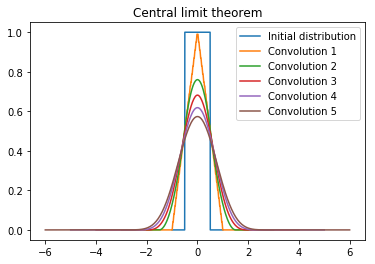

In [30]:
f = uniform(-0.5,0.5);# Распределение, над которым мы экспериментируем
wind = 1; # ширина окна интегрирования

fs = [f];
# fs << f;
x = np.linspace(-wind, wind, 300)
plt.title("Central limit theorem");
plt.plot(x, f(x),label="Initial distribution")

for i in range(1,6):
    wi = (i+1)*wind
    fs.append(interpolate(convolute(fs[i-1],f,-wind,wind),-wi,wi))
    x = np.linspace(-wi, wi, 300, endpoint=True)
    plt.plot(x, fs[i](x), label = "Convolution "+str(i))


plt.legend();

In [56]:
f = uniform(-0.5,-0.3) + uniform(0.3,0.5);# Распределение, над которым мы экспериментируем
wind = 1; # ширина окна интегрирования

fs = [f];
x = np.linspace(-wind, wind, 300)
traces = []
traces.append(go.Scatter(x = x, y = f(x),name="Initial distribution"))


for i in range(1,6):
    wi = (i+1)*wind
    fs.append(interpolate(convolute(fs[i-1],f,-wind,wind),-wi,wi))
    x = np.linspace(-wi, wi, 300, endpoint=True)
    traces.append(go.Scatter(x = x, y = fs[i](x), name = "Convolution "+str(i)))

iplot(traces)

TypeError: unsupported operand type(s) for +: 'vectorize' and 'vectorize'